# Practice with simple small graph

In [22]:
from dotenv import load_dotenv

_ = load_dotenv()

In [10]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

In [4]:
class AgentState(TypedDict):
    lnode: str
    pad: str
    count: Annotated[int, operator.add]

In [6]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1}

def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1}

def should_continue(state: AgentState) -> bool:
    return state["count"] < 3

The graph should go N1 -> N2 -> N1 but break

In [11]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", should_continue, { True: "Node1", False: END})
builder.set_entry_point("Node1")

#memory = SqliteSaver.from_conn_string(":memory:")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [12]:
thread = {"configurable": {"thread_id": "1"}}

graph.invoke({"count": 0, "pad": "Hello"}, thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'pad': 'Hello', 'count': 4}

# Let's investigate

In [15]:
display(graph.get_state(thread))

StateSnapshot(values={'lnode': 'node_2', 'pad': 'Hello', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc1a-6a46-8004-4807462a87ee'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-12T11:25:01.914366+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-6fd4-8003-df0ed3cd81a3'}}, tasks=(), interrupts=())

In [16]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'pad': 'Hello', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc1a-6a46-8004-4807462a87ee'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-12T11:25:01.914366+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-6fd4-8003-df0ed3cd81a3'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'pad': 'Hello', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-6fd4-8003-df0ed3cd81a3'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-12T11:25:01.913692+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-64a8-8002-8d44223bf0d8'}}, tasks=(PregelTask(id='61e78077-0618-e2cc-88a0-66ebc59b14ab', name='Node2', path=('__pregel_pull',

In [17]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc1a-6a46-8004-4807462a87ee'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-6fd4-8003-df0ed3cd81a3'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-64a8-8002-8d44223bf0d8'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc16-6a04-8001-9c1eeef210fa'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc14-6e20-8000-ed6546805b09'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc12-651c-bfff-7eaf9c73fa9e'}} 0


In [18]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'pad': 'Hello', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc16-6a04-8001-9c1eeef210fa'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-12T11:25:01.912723+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc14-6e20-8000-ed6546805b09'}}, tasks=(PregelTask(id='a803e457-082e-5763-33cb-0bf4e0ce992e', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

# Go back in time

In [19]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'pad': 'Hello', 'count': 4}

In [20]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-783c-6270-8004-6ea844f1aa45'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-783a-607e-8003-ed139a52baf6'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-7838-6c10-8002-6ce795fcd473'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc1a-6a46-8004-4807462a87ee'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-6fd4-8003-df0ed3cd81a3'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc18-64a8-8002-8d44223bf0d8'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc16-6a04-8001-9c1eeef210fa'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0776ef-cc14-6e20-8000-ed6546805b09'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

Notice how the new states are not in the history from the counts

In [21]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'pad': 'Hello', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-783c-6270-8004-6ea844f1aa45'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-12T11:36:31.052236+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-783a-607e-8003-ed139a52baf6'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'pad': 'Hello', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-783a-607e-8003-ed139a52baf6'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-12T11:36:31.051373+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f077709-7838-6c10-8002-6ce795fcd473'}}, tasks=(PregelTask(id='568bc7ee-8f44-e88e-8006-5fd846d7ecef', name='Node2', path=('__pregel_pull',

# Modifying states

Start with a new thread

In [26]:
thread2 = {"configurable": {"thread_id": "2"}}
graph.invoke({"count": 0, "pad": "hi"}, thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'pad': 'hi', 'count': 4}

In [29]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

ImportError: Install pygraphviz to draw graphs: `pip install pygraphviz`.

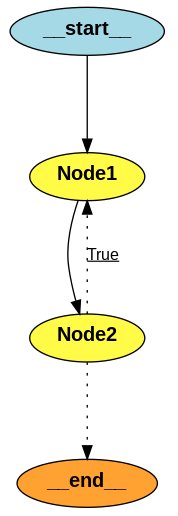

In [30]:
state2 = []
for state in graph.get_state_history(thread2):
    state2.append(state)
    print(state.config, state.values["count"])

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8eca-6016-8004-348e4350a513'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ec9-60d0-8003-0505aa6e9cd2'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ec7-6870-8002-e777e75e1b85'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ec5-63d6-8001-44418b3635dd'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ec3-6946-8000-a99ec0dd7a29'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ebb-62b4-bfff-cee83412c70b'}} 0


In [31]:
save_state = state2[-3]

In [32]:
save_state.values["count"] = -3
save_state.values["pad"] = "world"

save_state

StateSnapshot(values={'lnode': 'node_1', 'pad': 'world', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ec5-63d6-8001-44418b3635dd'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-16T10:01:53.233191+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8ec3-6946-8000-a99ec0dd7a29'}}, tasks=(PregelTask(id='98951f99-a786-9154-8d2b-9d1b3382a004', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

In [33]:
graph.update_state(thread2, save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07a88f-4b14-6f42-8005-abea5c0196e0'}}

In [34]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >=3:
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'pad': 'world', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a88f-4b14-6f42-8005-abea5c0196e0'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2025-08-16T10:08:28.788694+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8eca-6016-8004-348e4350a513'}}, tasks=(PregelTask(id='f05b17aa-a830-2873-a900-28f95061b380', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_2', 'pad': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a880-8eca-6016-8004-348e4350a513'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-16T10:01:53.235142+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'che

Do the same with using `as_node`

In [35]:
graph.update_state(thread2, save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07a898-a087-6408-8006-14f916b31c9c'}}

In [36]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >=3:
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'pad': 'world', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a898-a087-6408-8006-14f916b31c9c'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2025-08-16T10:12:39.340328+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a88f-4b14-6f42-8005-abea5c0196e0'}}, tasks=(PregelTask(id='06e6085a-9515-c0ca-6751-cc9f4eb2b178', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'pad': 'world', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a88f-4b14-6f42-8005-abea5c0196e0'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2025-08-16T10:08:28.788694+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint

In [37]:
graph.invoke(None, thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'pad': 'world', 'count': 3}

In [38]:
for state in graph.get_state_history(thread2):
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_2', 'pad': 'world', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a89b-2bb8-60ca-800b-b3ff69e0d42c'}}, metadata={'source': 'loop', 'step': 11, 'parents': {}}, created_at='2025-08-16T10:13:47.622619+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a89b-2bb7-6846-800a-4fdb634ef10a'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'pad': 'world', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a89b-2bb7-6846-800a-4fdb634ef10a'}}, metadata={'source': 'loop', 'step': 10, 'parents': {}}, created_at='2025-08-16T10:13:47.622401+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07a89b-2bb6-6806-8009-62b389b5d8bc'}}, tasks=(PregelTask(id='54a5fb61-8fa6-08f3-4c87-d119dae15e07', name='Node2', path=('__pregel_pull